<h1>Human body Segmentation using machine Learning<\h1>
    
**************************************

In this notebook, we explore the task of segmenting the human body in an image using machine Learning techniques. 
To do so, two approaches are implemented:
- **Kmeans** with k=2 for a binary segmentation
    - This approach is also compared to a segmentation by pixel intensity threshold 
- **Convolutional neural networks** with an autoencoder architecture to output a pixel-wise classified image (Background, body)
    
The dataset used for the training is composed of **290 images and their respective masks** (ground truth segmentation of the human body).<br>
This dataset was obtained here: https://github.com/VikramShenoy97/Human-Segmentation-Dataset.<br>
We perform a **preprocessing** of the dataset before performing **data augmentation** (left right flip and upside down flip) to obtain a dataset of 870 images.<br>
The dataset is then split into 90% for training and 10% for testing<br>

In [1]:
# import libraries

import numpy as np
import os
import matplotlib.pyplot as plt
from random import randrange

import skimage.io as io
from skimage.color import gray2rgb, rgb2gray
from skimage.transform import resize, rotate
from skimage.filters import threshold_otsu
from skimage.feature import canny
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, disk

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from utils import Dataset, accuracy, recall, specificity, compute_metrics, precision, print_metrics

In [2]:
path_to_notebook = os.getcwd()

folder = path_to_notebook + "/Data"
train_folder = folder + "/Training_Images"
gt_folder = folder + "/Ground_Truth"

In [3]:
#size of images
W, H, channels = 128, 128, 3
data_augmentation = 3

<h2>load and Construct the dataset</h2>

***********************

In [4]:
train_size = 289

In [5]:
dataset = Dataset(folder, data_augmentation, W, H, channels, train_size)
X, true_labels = dataset.load_and_pepare_train_data(), dataset.load_and_pepare_ground_truth()

In [6]:
# 90% - 10% split for train - test
X_train, X_test, y_train, y_test = train_test_split(X, true_labels, test_size=0.1)

In [7]:
#randomly select sample to train Kmeans
image_index = randrange(1, X_train.shape[0])
sample_img  = X[image_index-1]
image_index

59

<h2>Visualization of a sample of the dataset and its true pixel-wise segmentation</h2>

*********************

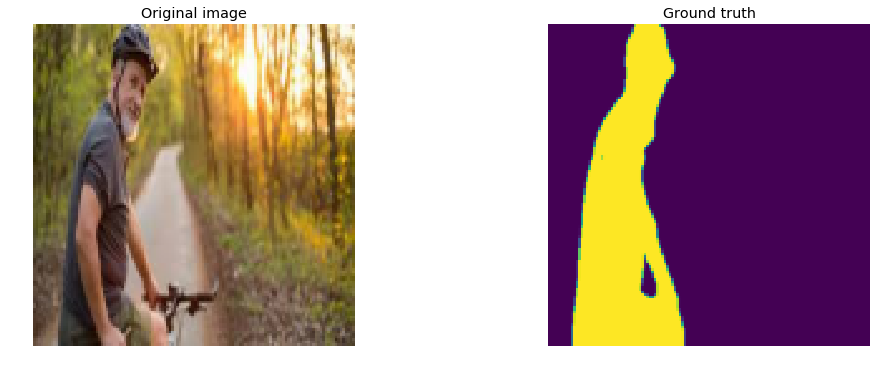

In [36]:
dataset.subplot_img_and_gt_mask(image_index)

<h2>First approach: Segmentation by threshold</h2>

**************

Text(0.5,1,'histogram of pixels of the sample 142')

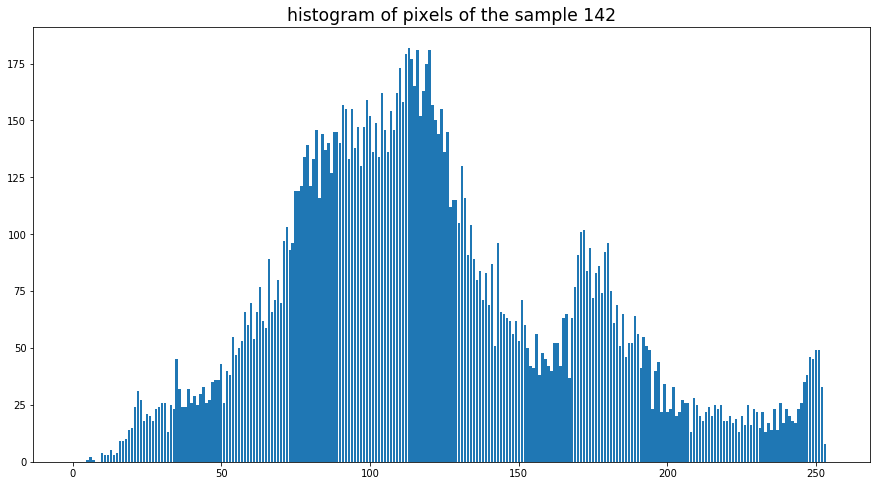

In [37]:
gray_sample_img = rgb2gray(sample_img)

plt.figure(figsize=(15,8))
histogram, bins = np.histogram(gray_sample_img*255, bins=range(257))
bins = bins[:-1]
plt.bar(bins, histogram)
plt.title("histogram of pixels of the sample {}" .format(image_index), size="xx-large")

In [38]:
mean = np.mean(gray_sample_img)
std = np.std(gray_sample_img)
print ("mean value of pixels:", int(mean*255), "\nstd value of pixels:", int(std*255))

mean value of pixels: 121 
std value of pixels: 49


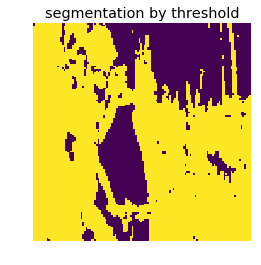

accuracy : 50.750732421875


In [39]:
img_threshold = threshold_otsu(gray_sample_img)
thresholded_gray_sample = ( (gray_sample_img > img_threshold )*1)
thresholded_gray_sample = ( (thresholded_gray_sample < img_threshold )*1)

plt.figure()
plt.imshow(thresholded_gray_sample)
plt.axis('off')
plt.title("segmentation by threshold", size= "x-large")
plt.show()

threshold_accuracy = accuracy(thresholded_gray_sample, true_labels[image_index-1])

print ("accuracy :", threshold_accuracy)

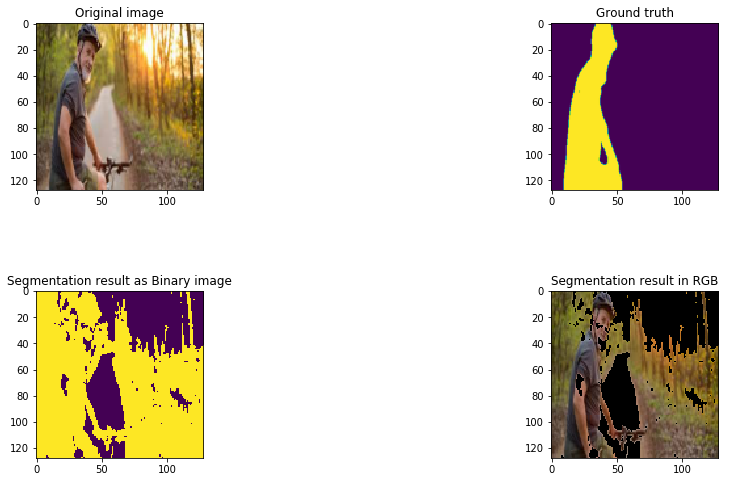

In [40]:
dataset.subplot_segmentation(image_index, thresholded_gray_sample)

<h3>A look at different metrics of classification</h3>

****************

A quick look at the metrics in the cell below show that **only taking the accuracy as a metric could lead to wrong conclusions** .<br>
Classes are not always balanced in the input. Therefore, using accuracy as the only metric is not the best way to evaluate the model.
    
- For example, the Background is dominant in this picture (77%), while the human person is only (22%). Therefore, returning a black image (all pixels as background) would result in a considerably high accuracy (77%).
This is why it is important to look at different metrics for classification, such as:
    - **precision** (How accurate the positive predictions are)
    - **recall sensitivity** (Coverage of actual positive sample)
    - **specificity** (Coverage of actual negative sample)
    - **balanced_accuracy**

In [41]:
threshold_metrics = print_metrics(thresholded_gray_sample, true_labels[image_index-1])

percentage of background in the image: 77.5390625
percentage of body in the image: 22.4609375

accuracy: 50.750732421875
precision: 26.93321616871705
recall: 83.28804347826086
specificity: 65.45182619647355
balanced accuracy: 74.3699348373672


<h3>Comments on the metrics</h3>

In this example, **the most representative metric is precision**, which shows that the positive predictions around the human body are not accurate at all (26%), meaning that our classifier is **not performing well** and is not able to classify Backgound pixels from human body pixels

<h2>Second approach: Segmentation with Kmeans</h2>

**************

The second approach we are investigating here is **Kmeans clustering**.<br>
In this part, we are performing a clustering of an input image into 2 clusters: Background and human body.<br>
- To do so, we have tried the following:
    - Feeding as input an RGB image of a shape=(256,256,3). 
    - Feeding as input an RGB image with canny edges as features. The shape of the image is then (256,256,4)
<br>

<br>
<h2>Kmeans with RGB image as features</h2>

In [42]:
#train Kmeans with 2 clusters on the randomly generated image
kmeans = KMeans(init="random",
                 n_clusters=2,
                 n_init=20,
                 max_iter=300)

x = np.reshape(sample_img, (sample_img.shape[0]*sample_img.shape[1], 3))

kmeans.fit(x)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
kmeans_result = np.reshape(labels, (sample_img.shape[0], sample_img.shape[1]))

Text(0.5,1,'segmentation by Kmeans (K=2, RGB as features)')

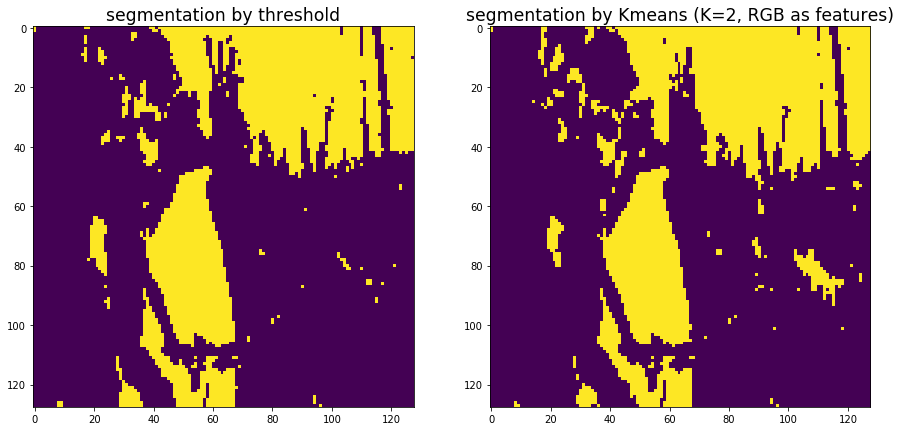

In [57]:
fig, ax = plt.subplots(1,2, figsize=(15, 10))

ax[0].imshow(~kmeans_result)
ax[0].set_title("segmentation by threshold", size= "xx-large")

ax[1].imshow(~thresholded_gray_sample)
ax[1].set_title("segmentation by Kmeans (K=2, RGB as features)", size= "xx-large")

In [44]:
kmeans_rgb_accuracy = accuracy(kmeans_result, true_labels[image_index-1])
print ("Kmeans accuracy (RGB as features) :", kmeans_rgb_accuracy)
print ("Segmentation by threshold accuracy :", threshold_accuracy)

Kmeans accuracy (RGB as features) : 53.314208984375
Segmentation by threshold accuracy : 50.750732421875


<h3>Visualization of a sample of the dataset</h3>

- In the figure above, we can see that a **Kmeans with 2 clusters basically performs a segmentation by threshold** when having RGB values of the sample image as features.
- We should try to **select/construct more features** to guide Kmeans learning towards the objective of **segmenting the picture into two clusters: Background and human body** 

<br>
<h2> Feature selection </h2>

*********** 
- One of the important information that images contain are the **edges**: They help locate the **frontiers between different objects of an image** when present.
- One possible feature is the canny filter:
    - Canny filter performs a **cleaning of the image from noise** via gaussian filter, followed by a **gradient thresholded operation to extract edges location**
- We can try to use this information to help our algorithms perform the segmentation (which in this case is a binary classification of the pixels of an image)

In [66]:
nb_tests = 10
nb_test_plots = int(nb_tests/2)
canny_results = []

for i in range(nb_tests):
    canny_results.append(canny(gray_sample_img, sigma=i).astype(int))

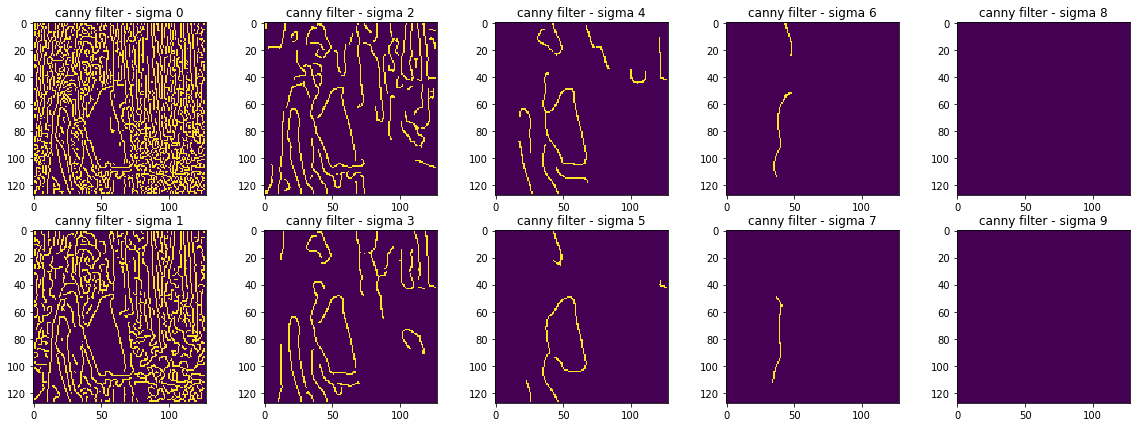

In [67]:
fig, ax = plt.subplots(2, nb_test_plots, figsize=(20, 7))

for i in range(nb_test_plots):
    ax[0, i].imshow(canny_results[2*i])
    ax[0, i].set_title("canny filter - sigma {}" .format(2*i))
    ax[1, i].imshow(canny_results[2*i + 1])
    ax[1, i].set_title("canny filter - sigma {}" .format(2*i+1))

**A look at the different results of the plots above shows that a low sigma won't be discriminative enough with the backgound objects. Therefore, it is necessary to choose a higher sigma (3 or 4)**

In [68]:
def add_feature(x, feature):
    new_x = np.zeros((x.shape[0], x.shape[1] + 1))
    new_x[:, 0:x.shape[1]] = x
    new_x[:, x.shape[1]]   = feature
    return new_x

In [69]:
sigma = 3

canny_result = canny_results[sigma].reshape(x.shape[0])
x_canny = add_feature(x, canny_result)

In [70]:
kmeans2 = KMeans(init="random",
                 n_clusters=2,
                 n_init=20,
                 max_iter=300)

kmeans2.fit(x_canny)
centroids2 = kmeans2.cluster_centers_
labels2 = kmeans2.labels_
kmeans_result1 = np.reshape(labels2, (sample_img.shape[0], sample_img.shape[1]))

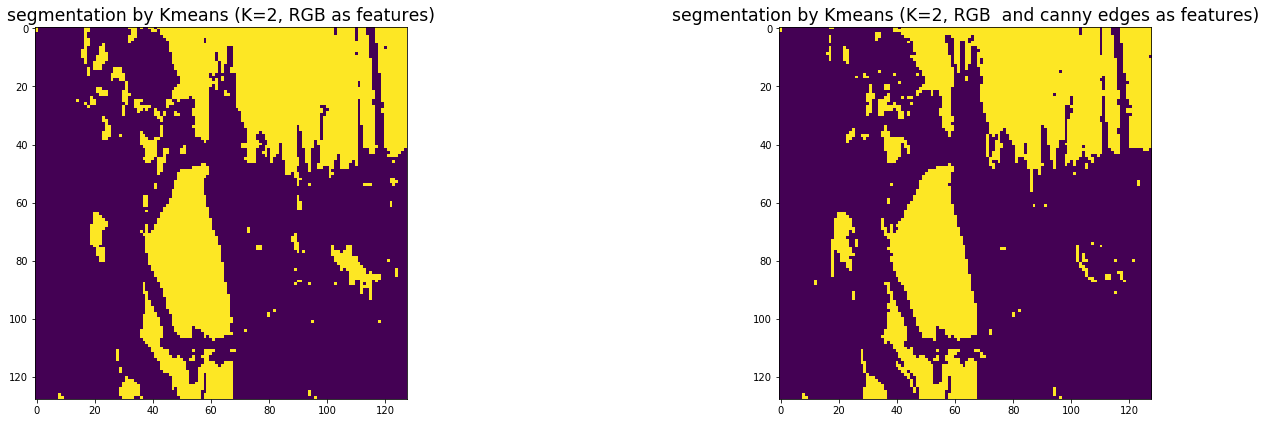

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))

ax[0].imshow(~thresholded_gray_sample)
ax[0].set_title("segmentation by Kmeans (K=2, RGB as features)", size= "xx-large")

ax[1].imshow(~kmeans_result1)
ax[1].set_title("segmentation by Kmeans (K=2, RGB  and canny edges as features)", size= "xx-large")

plt.subplots_adjust(wspace=1)

In [64]:
print ("Kmeans with RGB & Canny edges features metrics:\n\n")
kmeans_RGB_canny_metrics = print_metrics(kmeans_result1, true_labels[image_index-1])

Kmeans with RGB & Canny edges features metrics:


percentage of background in the image: 77.5390625
percentage of body in the image: 22.4609375

accuracy: 53.070068359375
precision: 25.172117039586915
recall: 79.4836956521739
specificity: 68.44301007556675
balanced accuracy: 73.96335286387033


In [65]:
print ("Threshold metrics:\n\n")
threshold_metrics = print_metrics(thresholded_gray_sample, true_labels[image_index-1])

Threshold metrics:


percentage of background in the image: 77.5390625
percentage of body in the image: 22.4609375

accuracy: 50.750732421875
precision: 26.93321616871705
recall: 83.28804347826086
specificity: 65.45182619647355
balanced accuracy: 74.3699348373672


<br><br>
<h3>Effect of canny edges as features</h3>

- The **canny edges feature hasn't improved the semgmentation task** as we can see with the metrics. In fact, in some cases (not shown here), it has worsened the result by adding some unwanted pixels to the image (background sharp objects). 
- In this example, **The accuracy barely increased from 50% to 53%**.<br>
- The same applies to the other metrics which stayed around the same.<br>
<br>

**Therefore, this feature is not useful for our task**


<br>
<h3>Accuracy over the test dataset (for a comparison with the CNN model)</h3>

********************


In [96]:
avg_kmeans_accuracy = 0
avg_kmeans_precision = 0
avg_kmeans_recall= 0
avg_kmeans_specificity = 0
for i in range(len(X_test)):
    x = X_test[i].copy()
    x = np.reshape(x, (W*H, 3))
    kmeans.fit(x)
    labels = kmeans.labels_
    curr_kmeans_result = np.reshape(labels, (W,H))
    
    
    avg_kmeans_accuracy += accuracy(curr_kmeans_result, y_test[i])
    avg_kmeans_precision += precision(curr_kmeans_result, y_test[i])
    avg_kmeans_recall += recall(curr_kmeans_result, y_test[i])
    avg_kmeans_specificity += specificity(curr_kmeans_result, y_test[i])

avg_kmeans_accuracy /= len(X_test)
avg_kmeans_precision /= len(X_test)
avg_kmeans_recall /= len(X_test)
avg_kmeans_specificity /= len(X_test)

In [98]:
print("\naccuracy:",avg_kmeans_accuracy)
print("precision:",avg_kmeans_precision)
print("recall:",avg_kmeans_recall)
print("specificity:",avg_kmeans_specificity)


accuracy: 61.528278219288794
precision: 53.193788589289404
recall: 71.95838820686032
specificity: 73.18919424843877


<br>
<h3>Kmeans Conclusions:</h3>

********************
- Overall, **Kmeans clustering is not performing well with the current preprocessing and features**.<br>
- The obtained results show an **overall accuracy on the test set (87 images) of 61%** and a **precision of 53%**, meaning our **Kmeans implementation is slightly above average**<br>
- These results are obtained through a **very basic implemenation of the Kmeans algorithm with no preprocessing**. The model can be **further improved by applying prior preprocessing** to the images through **mathematical morphology** and a **ROI** determination to **avoid complex backgrounds** and reduce the area of segmentation
- **Feature engineering is critical to the performance of the model**. Further work should be done to guide Kmeans towards good segmentation 

<br><br><br>
<h2>Third approach: Segmentation using an autoencoder (convolutional neural network CNN)</h2>

**************

The third approach we are investigating here is **Autoencoders** using **CNN**.<br>
The autoencoder architecture allows to perform a **pixel-wise binary classification** where each pixel is classified as “person” or “background”, thus the use of the **sigmoid activation function in the last layer**. <br>
The idea behind this architecture is to **learn the image at a large scale at first**, then **focusing on smaller regions of the image in the next encoder layers**, up to the **last encoder layer where very specific details of the image are learned**. <br>

- The **train test is composed of 780 RGB images**. They are then given to an autoencoder architecture to learn the segmentation task<br>
- The **test set is composed of 87 images**<br>
- The architecture of this model is displayed below<br>
- This model is achieving a better performance than the Kmeans model
<br><br><br>

In [8]:
import keras
from keras import layers

In [9]:
input_img = keras.Input(shape=(H, W, channels))

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Dropout(rate=0.25)(x) #25% dropout to avoid overfitting

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Dropout(rate=0.25)(x) #25% dropout to avoid overfitting

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = layers.Dropout(rate=0.25)(x) #25% dropout to avoid overfitting

# at this point the representation is (32, 32, 16)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Dropout(rate=0.25)(x) #25% dropout to avoid overfitting

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Dropout(rate=0.25)(x) #25% dropout to avoid overfitting

x = layers.Conv2D(8, (3, 3), activation='relu', padding= 'same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Dropout(rate=0.25)(x) #25% dropout to avoid overfitting

decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

model = keras.Model(input_img, decoded)
opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()])

In [10]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 16)       

In [11]:
X_train.shape, X_test.shape
print ("There are", X_train.shape[0],"training samples.")
print ("There are", X_test.shape[0],"test samples.")

There are 780 training samples.
There are 87 test samples.


In [12]:
history = model.fit(
                    x=X_train,
                    y=y_train,
                    batch_size=32,
                    epochs=50,
                    verbose=1,
                    shuffle=True,
                    validation_data=(X_test, y_test)
                    )

Epoch 1/50
25/25 [==============================] - 19s 779ms/step - recall: 0.0632 - auc: 0.4930 - accuracy: 0.6561 - loss: 0.6420 - precision: 0.2909 - val_loss: 0.6145 - val_auc: 0.5047 - val_accuracy: 0.7164 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
25/25 [==============================] - 19s 749ms/step - recall: 0.0046 - auc: 0.5298 - accuracy: 0.6870 - loss: 0.6151 - precision: 0.2638 - val_loss: 0.6111 - val_auc: 0.6222 - val_accuracy: 0.7164 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
25/25 [==============================] - 19s 756ms/step - recall: 0.0014 - auc: 0.6227 - accuracy: 0.6891 - loss: 0.5815 - precision: 0.2471 - val_loss: 0.5507 - val_auc: 0.7526 - val_accuracy: 0.7164 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
25/25 [==============================] - 19s 760ms/step - recall: 1.6894e-04 - auc: 0.7105 - accuracy: 0.6899 - loss: 0.5487 - precision: 0.1779 - val_loss: 0.5030 - val_auc: 0.7857 - val_accura

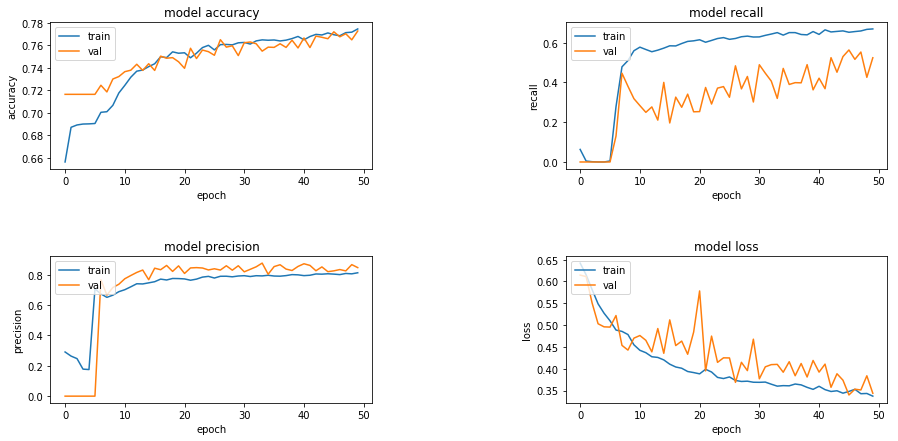

In [20]:
fig, ax = plt.subplots(2, 2, figsize = (15,7))
fig.subplots_adjust(wspace=0.6, hspace=0.6)

ax[0,0].plot(history.history['accuracy'])
ax[0,0].plot(history.history['val_accuracy'])
ax[0,0].set_title('model accuracy')
ax[0,0].set_ylabel('accuracy')
ax[0,0].set_xlabel('epoch')
ax[0,0].legend(['train', 'val'], loc='upper left')

ax[0,1].plot(history.history['recall'])
ax[0,1].plot(history.history['val_recall'])
ax[0,1].set_title('model recall')
ax[0,1].set_ylabel('recall')
ax[0,1].set_xlabel('epoch')
ax[0,1].legend(['train', 'val'], loc='upper left')

ax[1,0].plot(history.history['precision'])
ax[1,0].plot(history.history['val_precision'])
ax[1,0].set_title('model precision')
ax[1,0].set_ylabel('precision')
ax[1,0].set_xlabel('epoch')
ax[1,0].legend(['train', 'val'], loc='upper left')

ax[1,1].plot(history.history['loss'])
ax[1,1].plot(history.history['val_loss'])
ax[1,1].set_title('model loss')
ax[1,1].set_ylabel('loss')
ax[1,1].set_xlabel('epoch')
ax[1,1].legend(['train', 'val'], loc='upper left')

plt.savefig("Metrics - CNN model")

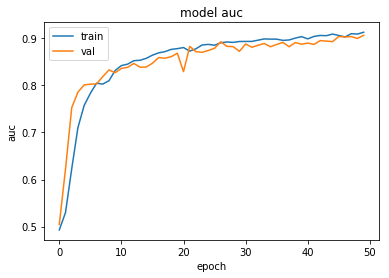

In [16]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("AUC - CNN model")

In [17]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 1s 385ms/step - recall: 0.5241 - auc: 0.9064 - accuracy: 0.7729 - loss: 0.3437 - precision: 0.8464


[0.3436734080314636,
 0.7728622555732727,
 0.8464187383651733,
 0.5240775346755981,
 0.9063585996627808]

In [ ]:
random_index_test = randrange(start=0, stop=X_test.shape[0])
pred = model.predict([X_test[random_index_test: random_index_test+1 ]])
random_index_test

In [53]:
pred = pred.reshape(H,W)

pred[pred < 0.5] = 0
pred[pred >= 0.5] = 1

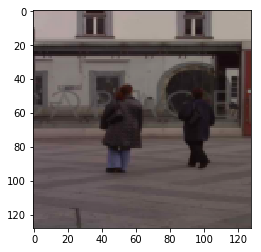

In [54]:
plt.imshow(X_test[random_index_test])

Text(0.5,1,'CNN RGB segmentation result')

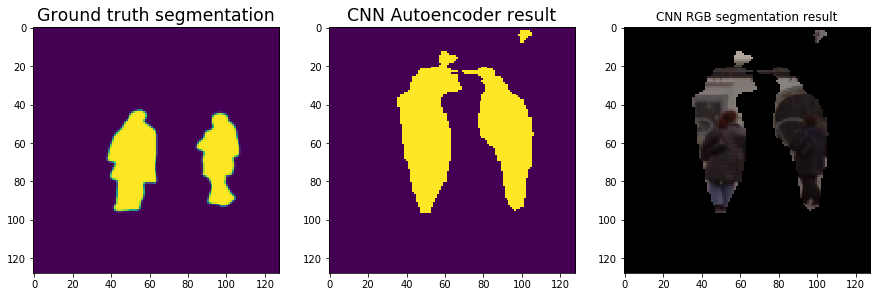

In [55]:
fig, ax = plt.subplots(1,3, figsize=(15, 10))

segm_pixels_map = np.where((pred == 0))
segm_rgb = X_test[random_index_test].copy()

for i in range(len(segm_pixels_map[0])):
    row, col = segm_pixels_map[0][i], segm_pixels_map[1][i]
    segm_rgb[row, col] = 0

ax[0].imshow(y_test[random_index_test])
ax[0].set_title("Ground truth segmentation", size= "xx-large")

ax[1].imshow(pred)
ax[1].set_title("CNN Autoencoder result", size= "xx-large")

ax[2].imshow(segm_rgb)
ax[2].set_title("CNN RGB segmentation result")

In [59]:
CNN_sample_metrics = print_metrics(pred, y_test[random_index_test])

percentage of background in the image: 88.4521484375
percentage of body in the image: 11.5478515625

accuracy: 87.103271484375
precision: 55.254942767950055
recall: 84.19661733615223
specificity: 91.09853712393044
balanced accuracy: 87.64757723004134


accuracy: 89.61181640625


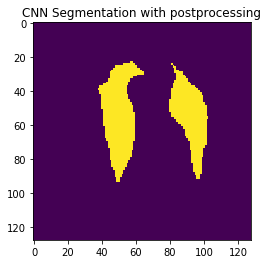

In [65]:
closed_pred = erosion(pred, disk(3))
plt.imshow(closed_pred)
plt.title("CNN Segmentation with postprocessing")
print ("accuracy:", accuracy(closed_pred, y_test[random_index_test]))